In [1]:
%pylab inline
import seaborn as sns
from scipy.stats import zscore
from pandas import read_csv
import CCD_packages

Populating the interactive namespace from numpy and matplotlib


/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [10]:
import nilearn.datasets
from nilearn import input_data

print('Datasets shipped with nilearn are stored in: %r' % nilearn.datasets.get_data_dirs())
atlas=nilearn.datasets.fetch_atlas_msdl()

GroupDF,motionInfo=CCD_packages.getCCDSubjectData()
goodsubj,badsubj = CCD_packages.getSubjectList(GroupDF=GroupDF,motionThresh=1)

Datasets shipped with nilearn are stored in: ['/home/jmuraskin/nilearn_data']
No DR .txt file found or error for subject : CCD061
No DR .txt file found or error for subject : CCD061


In [174]:



masker = nilearn.input_data.NiftiMapsMasker(
    atlas.maps, resampling_target="maps", detrend=False,
    t_r=2.0, standardize=True,
    memory='nilearn_cache', memory_level=1)


subjects = []
# sites = []
# adhds = []
for subj in goodsubj: 
    print 'Running Subject %s' % subj
    func_file='/home/jmuraskin/Projects/CCD/CPAC-out/pipeline_CCD_v1/%s_data_/functional_mni_other_resolutions_smooth/_scan_tra/_csf_threshold_0.96/_gm_threshold_0.7/_wm_threshold_0.96/_apply_isoxfm_3.0/_compcor_ncomponents_5_selector_pc10.linear1.wm0.global0.motion1.quadratic1.gm0.compcor1.csf1/_fwhm_6/residual_antswarp_maths.nii.gz' % subj
    time_series = masker.fit_transform(func_file)
    subjects.append(time_series)

# subj_time_series=[]
# for subj in goodsubj:
    
    
    
#     df=read_csv('/home/jmuraskin/Projects/CCD/CPAC-out/pipeline_CCD_v1/%s_data_/roi_timeseries/_scan_tra/_csf_threshold_0.96/_gm_threshold_0.7/_wm_threshold_0.96/_compcor_ncomponents_5_selector_pc10.linear1.wm0.global%d.motion1.quadratic1.gm0.compcor1.csf1/_mask_CC200/roi_stats.csv' % (subj,1),delim_whitespace=True)
#     df.drop(['File','Sub-brick'],axis=1,inplace=True)
#     subj_time_series.append(zscore(df.values,axis=0))

No DR .txt file found or error for subject : CCD061
No DR .txt file found or error for subject : CCD061
Running Subject CCD012


/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:430: UserWarning:

The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.



Running Subject CCD014
Running Subject CCD015
Running Subject CCD016
Running Subject CCD017
Running Subject CCD018
Running Subject CCD019
Running Subject CCD020
Running Subject CCD021
Running Subject CCD022
Running Subject CCD023
Running Subject CCD024
Running Subject CCD025
Running Subject CCD026
Running Subject CCD027
Running Subject CCD031
Running Subject CCD032
Running Subject CCD034
Running Subject CCD040
Running Subject CCD041
Running Subject CCD042
Running Subject CCD052
Running Subject CCD053
Running Subject CCD059
Running Subject CCD060
Running Subject CCD063
Running Subject CCD064
Running Subject CCD065
Running Subject CCD067
Running Subject CCD071
Running Subject CCD073
Running Subject CCD074
Running Subject CCD075
Running Subject CCD080
Running Subject CCD081
Running Subject CCD082
Running Subject CCD084
Running Subject CCD085
Running Subject CCD088
Running Subject CCD089
Running Subject CCD090
Running Subject CCD091
Running Subject CCD092
Running Subject CCD094
Running Sub

In [3]:
import pickle

load_or_save = 0
if load_or_save:
    favorite_color = { 'subjectTimeSeries': subjects}
    pickle.dump( favorite_color, open( "Train_MSDL_global0.p", "wb" ) )
else:
    favorite_color = pickle.load( open( "Train_MSDL_global0.p", "rb" ) )
    subjects=favorite_color['subjectTimeSeries']

In [4]:
import nilearn.connectome
kinds = ['tangent', 'partial correlation', 'correlation','precision']
individual_connectivity_matrices = {}
mean_connectivity_matrix = {}
for kind in kinds:
    conn_measure = nilearn.connectome.ConnectivityMeasure(kind=kind)
    individual_connectivity_matrices[kind] = conn_measure.fit_transform(
        subjects)
    # Compute the mean connectivity
    if kind == 'tangent':
        mean_connectivity_matrix[kind] = conn_measure.mean_
    else:
        mean_connectivity_matrix[kind] = \
            individual_connectivity_matrices[kind].mean(axis=0)

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



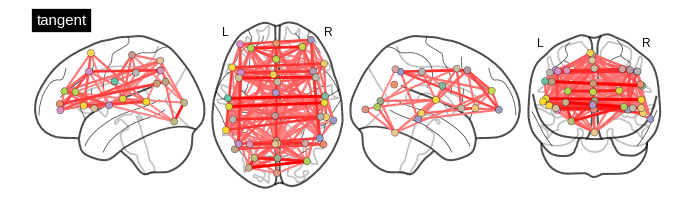

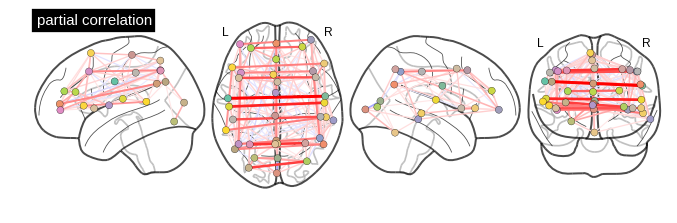

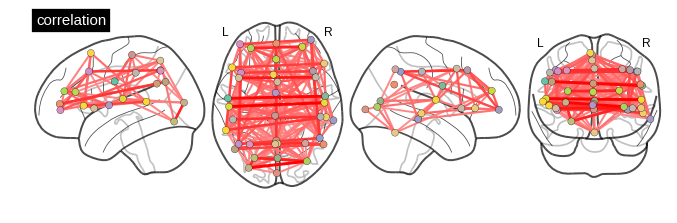

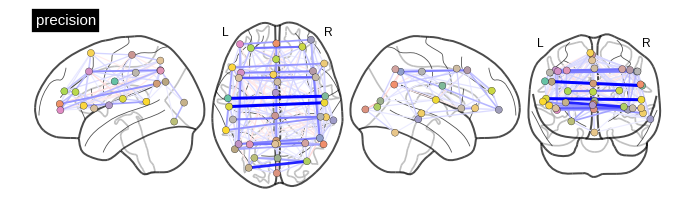

In [5]:
import nilearn.plotting
labels = atlas.labels
region_coords = atlas.region_coords
for kind in kinds:
    nilearn.plotting.plot_connectome(mean_connectivity_matrix[kind],
                                     region_coords, edge_threshold='75%',
                                     title=kind, display_mode='lzry')

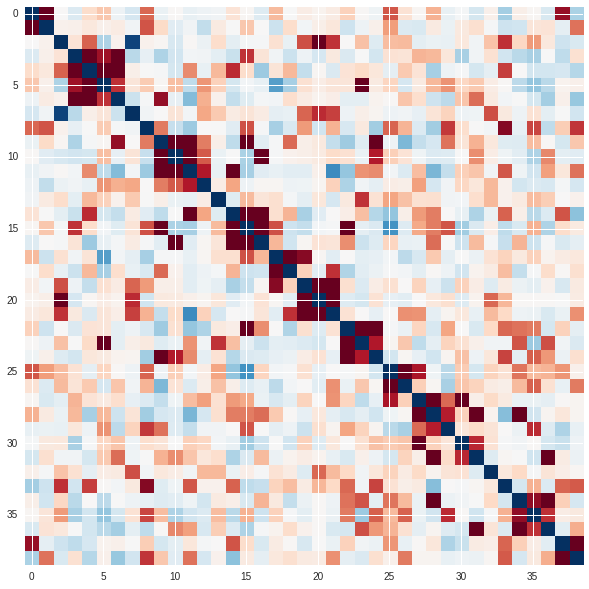

In [6]:
plt.figure(figsize=(10, 10))
# Mask the main diagonal for visualization:
CCD_packages.np.fill_diagonal(-mean_connectivity_matrix['precision'],0)

plt.imshow(-mean_connectivity_matrix['precision'], interpolation="nearest", cmap="RdBu_r",
           vmax=0.8, vmin=-0.8)

In [99]:
indices=CCD_packages.np.triu_indices(39,1)
performance=read_csv('/home/jmuraskin/Projects/CCD/CCD-scripts/analysis/CCD_performance.csv',names=['Subject_ID','FB','scanorder','R'])
fbNames=['FEEDBACK','NOFEEDBACK']
fb=0

In [106]:
import tempfile
from sklearn.linear_model import BayesianRidge,ARDRegression,ElasticNetCV,SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.externals.joblib import Memory
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut,KFold
from sklearn import feature_selection
from sklearn.metrics import r2_score
from sklearn.manifold import MDS

X=zscore(-individual_connectivity_matrices['precision'][:,indices[0],indices[1]],axis=0)
y=zscore(CCD_packages.np.arctanh(performance[performance.FB==fbNames[fb]][performance.Subject_ID.isin(goodsubj)]['R']).values)

elastic=0


def run_LOO_regression(X,y):
    cv=KFold(2)
    loo = LeaveOneOut()  # cross-validation generator for model selection
    ridge = ARDRegression()
    cachedir = tempfile.mkdtemp()
    mem = Memory(cachedir=cachedir, verbose=1)

    # Anova univariate feature selection followed by BayesianRidge
    f_regression = feature_selection.f_regression
    anova = feature_selection.SelectPercentile(f_regression)
    y_pred=np.zeros((len(y),))
    params=[]
    for train_index, test_index in loo.split(X):
        ("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if not elastic:
            clf = Pipeline([('anova', anova), ('ridge', ridge)])
#         Select the optimal percentage of features with grid search
            clf = GridSearchCV(clf, {'anova__percentile': [1, 5, 10, 15, 20]}, cv=cv,scoring='neg_mean_squared_error')

        else:
            paramsGB = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
              'learning_rate': 0.01, 'loss': 'ls'}
            clf = ensemble.GradientBoostingRegressor(**paramsGB)
        clf.fit(X_train, y_train)  # set the best parameters
    #     params.append(clf.coef_)
        y_pred[test_index]=clf.predict(X_test)
        if not elastic:
            coef_ = clf.best_estimator_.steps[-1][1].coef_
            coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_.reshape(1, -1))
        else:
            coef_ = clf.feature_importances_
        params.append(coef_)

    return y_pred,params

y_real,params = run_LOO_regression(X,y)
trueR2=r2_score(y,CCD_packages.np.reshape(y_real,len(y_real)))
permR2=[]
nperms=1000
import random
if nperms>0:
    for n in range(nperms):
        print n
        y_new=y.copy()
        random.shuffle(y_new)
        y_pred,_ = run_LOO_regression(X,y_new)
        permR2.append(r2_score(y_new,CCD_packages.np.reshape(y_pred,len(y_pred))))

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:12: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

0.100805411278
SpearmanrResult(correlation=0.41616558741905646, pvalue=0.003619914781778468)
(0.41762213297017836, 0.0034920358120388685)


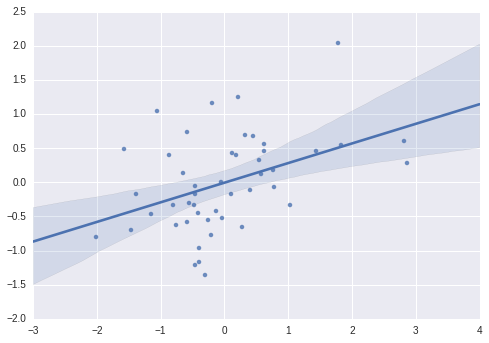

In [101]:

from scipy.stats import pearsonr,spearmanr
print r2_score(y,CCD_packages.np.reshape(y_real,len(y_real)))
print spearmanr(y,CCD_packages.np.reshape(y_real,len(y_real)))
print pearsonr(y,CCD_packages.np.reshape(y_real,len(y_real)))

sns.regplot(x=y,y=CCD_packages.np.reshape(y_real,len(y_real)))

if nperms>0:
    plt.figure()
    sns.distplot(permR2)

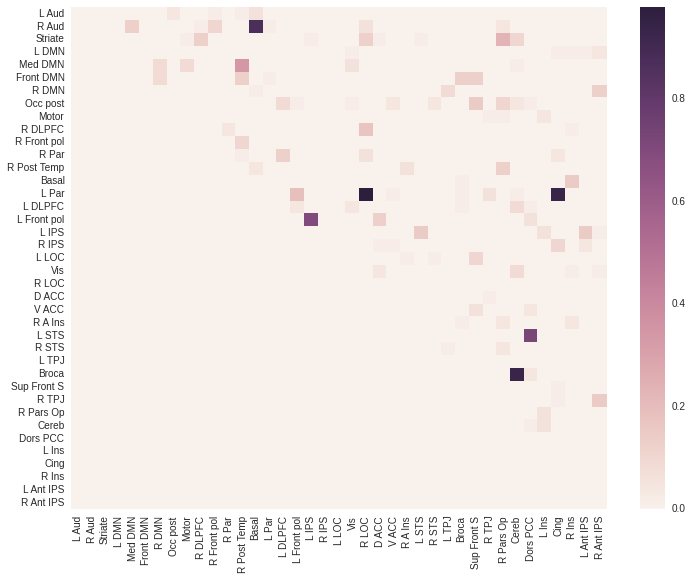

In [105]:
edgelist=CCD_packages.np.zeros((1,741))
for p in params:
    p[abs(p)!=0]=1.0
    edgelist+=p

edge_map=CCD_packages.np.zeros((39,39))
edge_map[indices]=edgelist/47
# edge_map[indices[1,:],indices[0,:]]=edgelist/47
plt.subplots(figsize=(12,9))
sns.heatmap(edge_map,xticklabels=labels,yticklabels=labels)

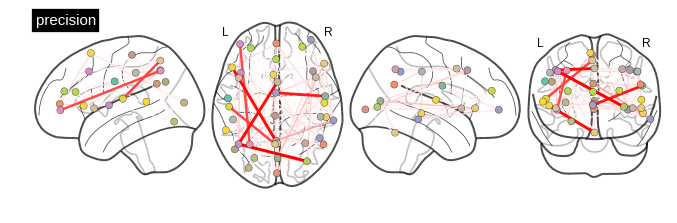

In [103]:
nilearn.plotting.plot_connectome((edge_map + edge_map.T)/2,
                                 region_coords, edge_threshold='90%',
                                 title=kind, display_mode='lzry')

0.014


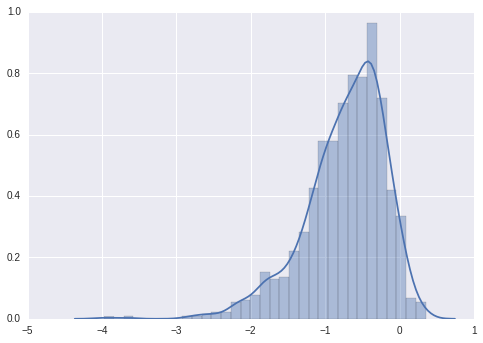

In [109]:
sns.distplot(permR2)
print np.float(sum(permR2>trueR2))/len(permR2)


In [113]:
sum(np.mean(params,axis=0)>0)

51

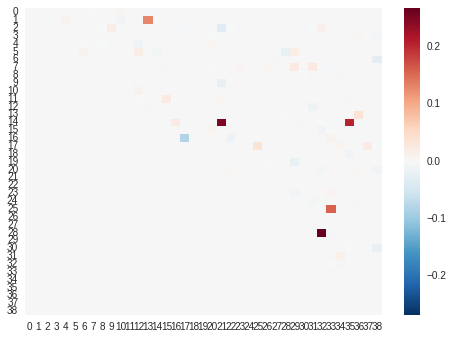

In [114]:
edge_map=CCD_packages.np.zeros((39,39))
edge_map[indices]=np.mean(params,axis=0)
sns.heatmap(edge_map)